In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')
from datetime import date
from statsmodels.stats.outliers_influence import variance_inflation_factor
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'
from seaborn_qqplot import pplot




/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_16865/1321555209.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


### Load mobility-heat and heatwave-control day dataframes

In [4]:
mobility_heat = pd.read_csv(data_path + 'mobility_heat/mobility_heat_clean_90.csv')

In [5]:
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_clean_90.csv')

In [7]:
heatwave_control.groupby('state')['Heat Wave Duration_x'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
British Columbia,357.0,4.212885,2.196665,2.0,2.0,3.0,6.0,11.0
California,765.0,3.819608,2.160178,2.0,2.0,3.0,5.0,11.0
Oregon,572.0,3.388112,1.821183,2.0,2.0,3.0,4.0,11.0
Washington,559.0,3.822898,1.936939,2.0,2.0,3.0,5.0,12.0


In [9]:
heatwave_control.rename(columns={'datetime': 'date'}, inplace=True)
heatwave_control.rename(columns={'Heat Wave Duration_x': 'Heat Wave Duration'}, inplace=True)


mobility_heat.rename(columns={'datetime': 'date'}, inplace=True)
heatwave_control.drop_duplicates(['location', 'date'], inplace=True)

## Build Intensity Variable


### Clean/Add control day temperature

In [ ]:
#load and format full temperature dataset

full_df = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/daily_max/max_temps/max_temps.csv')
full_df['datetime'] = pd.to_datetime(full_df['datetime'])
us_temps = full_df[full_df['state'].isin(['California', 'Oregon', 'Washington'])]
us_temps['county'] = us_temps['county'] + ' County'
us_temps['location'] = us_temps['county'] + ', ' + us_temps['state']

ca_temps = full_df[full_df['state'] == 'British Columbia']
ca_temps['location'] = ca_temps['county'] + ', ' + ca_temps['state']

nw_temps = us_temps.append(ca_temps)

In [ ]:
#remove days on Canadian holidays
holidays = pd.read_csv('/Users/shivyucel/Downloads/holidays.csv')
holidays['date'] = pd.to_datetime(holidays['date'])
mobility_heat['holiday'] = [1 if (x in holidays['date'].values) & (y=='British Columbia') else 0 for (x,y) in zip(mobility_heat['date_heat'], mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['holiday'] != 1]

In [ ]:
#remove days on American holidays

us_hols = pd.read_csv('/Users/shivyucel/Downloads/archive/400_Years_of_Generated_Dates_and_Holidays.csv')
us_hols = us_hols[us_hols['IS_HOLIDAY'] == 1]
us_hols['A_DATE'] = pd.to_datetime(us_hols['A_DATE'])
mobility_heat['us_holiday_heat'] = [1 if (x in us_hols['A_DATE'].values) & (y != 'British Columbia') else 0 for (x,y) in zip(mobility_heat['date_heat'], mobility_heat['state'])]
mobility_heat['us_holiday'] = [1 if (x in us_hols['A_DATE'].values) & (y != 'British Columbia') else 0 for (x,y) in zip(mobility_heat['date_control'], mobility_heat['state'])]
mobility_heat = mobility_heat[mobility_heat['us_holiday'] == 0]

In [14]:
# get heatwave control day difference (days)

In [15]:
mobility_heat[['date_heat','control_day']] = mobility_heat[['date_heat','control_day']].apply(pd.to_datetime) #if conversion required

mobility_heat['C'] = (mobility_heat['date_heat'] - mobility_heat['control_day']).dt.days

In [16]:
# get control day temperature
mobility_heat = mobility_heat.merge(nw_temps[['datetime', 'temperature_2m', 'location']], left_on=['location', 'control_day'], right_on=['location', 'datetime'], suffixes=('_heat', '_control'))

In [20]:
mobility_heat['temp_diff'] = mobility_heat['temperature_2m_heat'] - mobility_heat['temperature_2m_control']

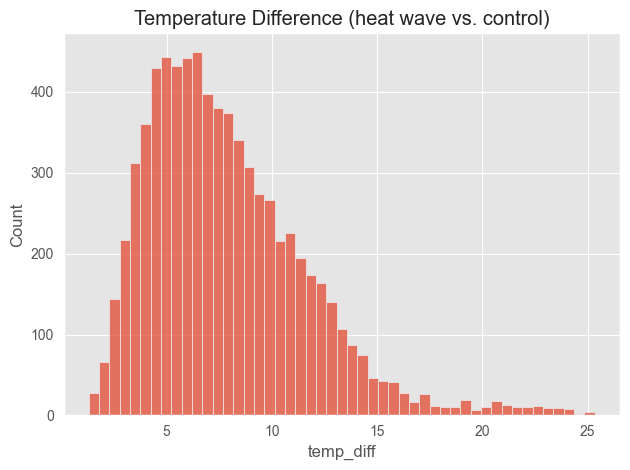

In [22]:
sns.histplot(mobility_heat, x='temp_diff')
plt.title("Temperature Difference (heat wave vs. control)")
plt.tight_layout()
#plt.savefig(data_path + '/img/12_09_2023/temp_diff_dist.png')

### Build Duration Variable
* Duration of heat wave (in days)
* Build stage variable showing how far a day is into a distinct heatwave

In [23]:
# Formatting column names and merging dataframes

In [24]:
heatwave_control.reset_index(inplace=True)

In [25]:
duration_IDs = heatwave_control.drop_duplicates('heat_ID')[['heat_ID', 'Heat Wave Duration']  ]             

In [26]:
duration_IDs.columns = ['heat_ID', 'Heat Wave Duration']

In [28]:
duration_IDs.head()

,heat_ID,Heat Wave Duration
0,8ef32a02-7165-40e1-b559-635edbcd1cc4,3.0
1,dbfe460c-49c7-493a-bc88-c033e6920abd,2.0
2,e803b7b8-7ff3-42bd-9785-ef7956662df6,3.0
3,51149baa-07b2-4878-b339-d7a43d56cf35,2.0
4,f136d5c5-7c4b-486f-8697-ef0d292efbbd,2.0


In [29]:
heatwave_control.drop('Heat Wave Duration', axis=1, inplace=True)
heatwave_control = heatwave_control.merge(duration_IDs, on='heat_ID', how='left')
heatwave_control.drop_duplicates(['location', 'date'], inplace=True)

heatwave_control['dur_ranking'] = heatwave_control['Heat Wave Duration'].rank(pct=True)

In [30]:
#create stage variable
heat_stage = heatwave_control.groupby('heat_ID').apply(lambda x: x.date.sort_values().rank()).reset_index()

In [31]:
heat_stage.columns=['heat_ID', 'index', 'stage']

In [738]:
heat_stage

,heat_ID,index,stage
0,00536be6-cad7-4a1b-97fa-1b763337df85,4201,1.0
1,00536be6-cad7-4a1b-97fa-1b763337df85,4299,2.0
2,00536be6-cad7-4a1b-97fa-1b763337df85,4398,3.0
3,00536be6-cad7-4a1b-97fa-1b763337df85,4464,4.0
4,0055a761-bfb7-4d65-84f7-1eb77e31e66f,976,1.0
...,...,...,...
8496,ffe375ec-afda-4d82-a5a2-57fdac046dc3,6978,3.0
8497,ffe375ec-afda-4d82-a5a2-57fdac046dc3,7003,4.0
8498,ffe6c341-1616-4128-8f73-eba5974d059d,2059,1.0
8499,ffe6c341-1616-4128-8f73-eba5974d059d,2061,2.0


In [32]:
heat_stage['stage'].max()

12.0

In [33]:
x = heat_stage.merge(duration_IDs, on='heat_ID')

In [741]:
#get stage variable as a fraction
(x['stage'] / x['Heat Wave Duration']).max()

1.0

# Merge Mobility data with temperature data

In [743]:
heatwave_control = heatwave_control.merge(heat_stage, on=['index', 'heat_ID'])

In [746]:
heatwave_control['date'] = pd.to_datetime(heatwave_control['date'])

In [ ]:
heatwave_control_us = heatwave_control[heatwave_control['state'].isin(['California', 'Oregon', 'Washington'])]
heatwave_control_us['county'] = heatwave_control_us['county'] + ' County'
heatwave_control_us['location'] = heatwave_control_us['county'] + ', ' + heatwave_control_us['state']

heatwave_control_ca = heatwave_control[heatwave_control['state'] == 'British Columbia']
heatwave_control_ca['location'] = heatwave_control_ca['county'] + ', ' + heatwave_control_ca['state']

heatwave_control = heatwave_control_us.append(heatwave_control_ca)

In [751]:
mobility_heat = mobility_heat.merge(heatwave_control[['heat_ID', 'location', 'date', 'Heat Wave Duration', 'dur_ranking', 'stage']], left_on=['location', 'date_heat'], right_on=['location', 'date'])

In [752]:
mobility_heat.reset_index(inplace=True)

In [753]:
mobility_heat[['date_heat','control_day']] = mobility_heat[['date_heat','control_day']].apply(pd.to_datetime) #if conversion required

mobility_heat['C'] = (mobility_heat['date_heat'] - mobility_heat['control_day']).dt.days

In [757]:
x = mobility_heat.copy()
x['stage_frac'] = (mobility_heat['stage'] / mobility_heat['Heat Wave Duration'] )

In [758]:
mobility_heat.to_csv(data_path + 'mobility_heat/mobility_heat_vars_clean_90.csv')